In [51]:
#AIC 502 Makine Öğrenmesi Ara Sınavı
#Vedat Sinan Ural - Yapay Zeka Y.L. (Tezli) 
#Öğrenci No: 25221001010

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.datasets import load_wine

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

import shap

Veri seti yükleme ve çerçeve oluşturma

In [52]:
#Veri seti yükleme
data = load_wine()

#X ve y değişkenlerini ayırma
X = data.data
y = data.target

#Veri çerçevesi oluşturma
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

#Veri çerçevesindeki X ve y değerleri
X_df = df.drop('target', axis = 1)
y_df = df['target']

İlk 5 satırı yazdırma

In [53]:
#İlk 5 satırı yazdırmak
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Kalite kontrolleri

In [54]:
#Kalite kontrolleri

#Eksik değer analizi
missing = X_df.isnull().sum()
print(f"Eksik değer miktarı: {missing.sum()}")

#Eksik değer olmadığı için doldurma yöntemi uygulanmasına gerek yoktur.

Eksik değer miktarı: 0


IQR ile outlier bulma

In [55]:
#IQR
Q1 = X_df.quantile(0.25) 
Q3 = X_df.quantile(0.75)

IQR = Q3 - Q1 

#Alt ve üst thresholdun dışındakiler outlier
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = ((X_df < lower) | (X_df > upper)).sum()
print(f"IQR - Aykırı değer miktarları:\n{outliers}")

IQR - Aykırı değer miktarları:
alcohol                         0
malic_acid                      3
ash                             3
alcalinity_of_ash               4
magnesium                       4
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 2
color_intensity                 4
hue                             1
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


Z-skoru ile outlier bulma

In [56]:
#Z-score
z_scores = np.abs(stats.zscore(X_df))

z_scores_df = pd.DataFrame(z_scores, columns=X_df.columns) 
outliers = (z_scores_df > 3) #z skoru 3'den büyük olanlar outlier

print(f"Z-skoru - Aykırı değer miktarları:\n{(outliers > 0).sum()}")

Z-skoru - Aykırı değer miktarları:
alcohol                         0
malic_acid                      1
ash                             3
alcalinity_of_ash               1
magnesium                       2
total_phenols                   0
flavanoids                      1
nonflavanoid_phenols            0
proanthocyanins                 1
color_intensity                 1
hue                             1
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


Veri tipi ve dağılımı inceleme

In [57]:
#Veri tipi ve dağılım incelemesi

#Sayısal ve kategorik değişkenler
numerical = X_df.select_dtypes(include=['float64', 'int64']).columns
categorical = X_df.select_dtypes(include=['object', 'category']).columns

print("\nDeğişken sayıları:")
print(f"Sayısal değişken: {len(numerical)}")
print(f"Kategorik değişken: {len(categorical)}")

#Veri tipi - her sütunun dtype bilgisi
print(f"\nVeri tipleri:\n{X_df.dtypes}")


Değişken sayıları:
Sayısal değişken: 13
Kategorik değişken: 0

Veri tipleri:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object


Keşifsel Veri Analizi

In [58]:
#EDA - Keşifsel Veri Analizi

#İstatistiksel özellikler
stats_df = pd.DataFrame({
    'Mean' : X_df.mean(),
    'Median': X_df.median(),
    'Min': X_df.min(),
    'Max': X_df.max(),
    'Std': X_df.std(),
    'Q1': X_df.quantile(0.25),
    'Q3': X_df.quantile(0.75)
    })

print(stats_df)

                                    Mean   Median     Min      Max  \
alcohol                        13.000618   13.050   11.03    14.83   
malic_acid                      2.336348    1.865    0.74     5.80   
ash                             2.366517    2.360    1.36     3.23   
alcalinity_of_ash              19.494944   19.500   10.60    30.00   
magnesium                      99.741573   98.000   70.00   162.00   
total_phenols                   2.295112    2.355    0.98     3.88   
flavanoids                      2.029270    2.135    0.34     5.08   
nonflavanoid_phenols            0.361854    0.340    0.13     0.66   
proanthocyanins                 1.590899    1.555    0.41     3.58   
color_intensity                 5.058090    4.690    1.28    13.00   
hue                             0.957449    0.965    0.48     1.71   
od280/od315_of_diluted_wines    2.611685    2.780    1.27     4.00   
proline                       746.893258  673.500  278.00  1680.00   

                   

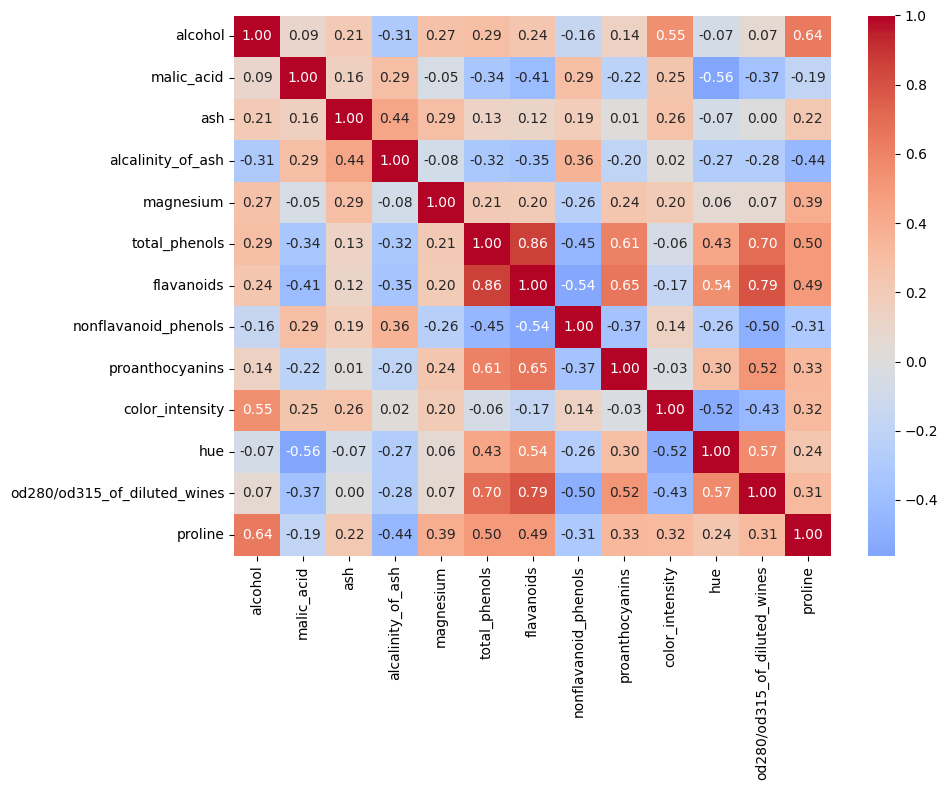

En yüksek korelasyonlu 3 çift:
total_phenols  flavanoids                      0.864564
flavanoids     od280/od315_of_diluted_wines    0.787194
total_phenols  od280/od315_of_diluted_wines    0.699949
dtype: float64


In [59]:
#Korelasyon matrisi

#Pearson korelasyon matrisi
corr_matrix = X_df.corr(method='pearson')

plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')

plt.tight_layout()
plt.show()

#En yüksek korelasyonlu 3 çift
corr_pairs = corr_matrix.unstack() #flatten
corr_pairs = corr_pairs[corr_pairs < 1.0] #self-correlation hariç

corr_pairs = corr_pairs.drop_duplicates() 
corr_pairs = corr_pairs.sort_values(ascending=False)

print(f"En yüksek korelasyonlu 3 çift:\n{corr_pairs.head(3)}")

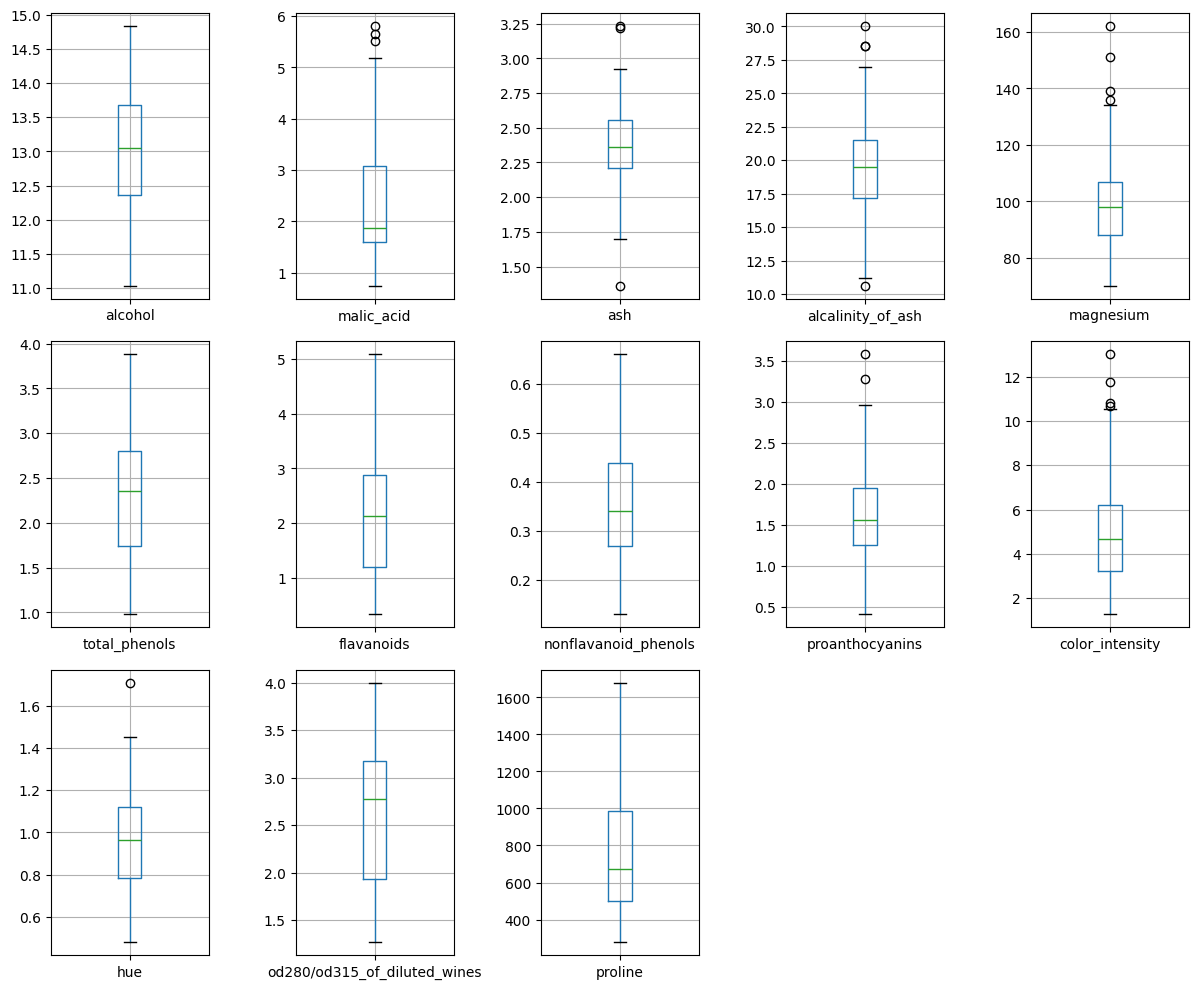

In [60]:
#Boxplot Analizi
fig, axes = plt.subplots(3,5, figsize=(12,10))
axes = axes.flatten()

for i, col in enumerate(X_df.columns):
    X_df.boxplot(column=col, ax=axes[i])
    #sns.boxplot(y=X_df[col], ax=axes[i])         

for i in range(13,15):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Veri Ölçeklendirme

In [61]:
#Veri Ölçeklendirme

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_df)
X_scaled = pd.DataFrame(X_scaled, columns=X_df.columns)

X_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


Veri Setinin Bölünmesi

In [62]:
#Veri Setinin Bölünmesi

#İlk split: 80(temp)-20(test)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_df, test_size=0.2, random_state=42)

#İkinci split: 70(training) - 10(validation). Yani 80'lik kısmın %12.5'i = 10
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

#Sanity check
print(f"Train: {len(X_train)} (%{len(X_train)/len(X_scaled)*100:.2f})")
print(f"Val:   {len(X_val)}  (%{len(X_val)/len(X_scaled)*100:.2f})")
print(f"Test:  {len(X_test)}  (%{len(X_test)/len(X_scaled)*100:.2f})")

Train: 124 (%69.66)
Val:   18  (%10.11)
Test:  36  (%20.22)


Özellik Seçimi ve Boyut İndirgeme

In [63]:
#PCA

pca_full = PCA()
pca_full.fit(X_train) #training'e PCA uygula

#Explained variance ratio bul
evr = pca_full.explained_variance_ratio_
evr_mean = evr.mean() #ortalama evr
print(f"Explained Variance Ratio:\n{evr}")
print(f"\nEVR Ortalama: {evr_mean:.5f}")

#EVR ortalamasından büyük olan bileşenler
n_components = (evr > evr_mean).sum()

print(f"Ortalama EVR'den büyük bileşen sayısı: {n_components}")

Explained Variance Ratio:
[0.35535125 0.18126514 0.11901077 0.07821516 0.07047396 0.05092089
 0.04164478 0.02720868 0.02346262 0.01730802 0.0151287  0.01169583
 0.00831422]

EVR Ortalama: 0.07692
Ortalama EVR'den büyük bileşen sayısı: 4


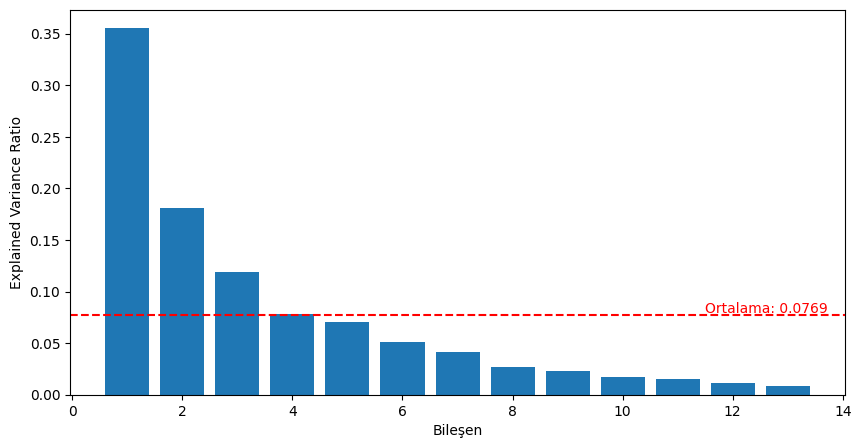

In [64]:
#Explained variance grafiği
plt.figure(figsize=(10,5))

plt.bar(range(1, len(evr)+1), evr)
plt.axhline(y=evr_mean, color='r', linestyle='--')
plt.text(len(evr) -1.5 , evr_mean, f'Ortalama: {evr_mean:.4f}', va='bottom', color='r')

plt.xlabel('Bileşen')
plt.ylabel('Explained Variance Ratio')
#plt.tight_layout()
plt.show()

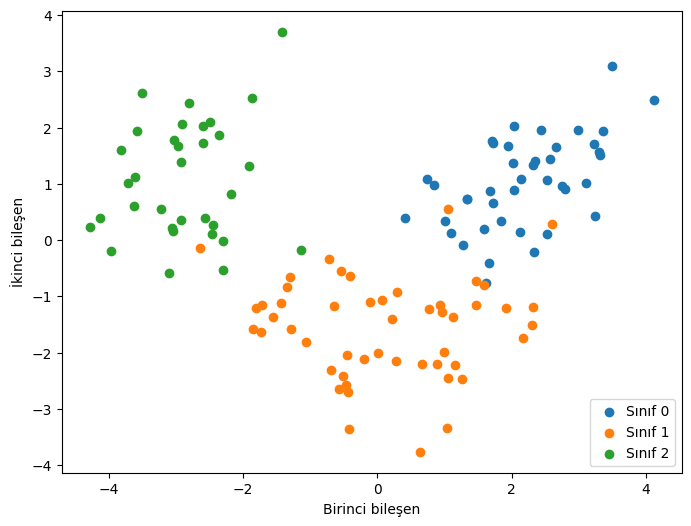

In [65]:
#En iyi iki PCA bileşeni ile 2D scatter plot

#Ortalama üstü bileşenler ile PCA uygula (dimension düşürüyoruz)
pca = PCA(n_components=n_components) #n_components = 4 çıktı yukarıda

X_train_pca = pca.fit_transform(X_train) #fit ile learn
X_val_pca = pca.transform(X_val)
X_test_PCA = pca.transform(X_test)

#Scatter plot - İlk iki PCA bileşeni ile
plt.figure(figsize=(8,6))

for label in [0, 1, 2]:
    mask = (y_train == label) 
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Sınıf {label}')


plt.xlabel('Birinci bileşen')
plt.ylabel('İkinci bileşen')
plt.legend(handletextpad=0.2, loc='lower right')
plt.show()

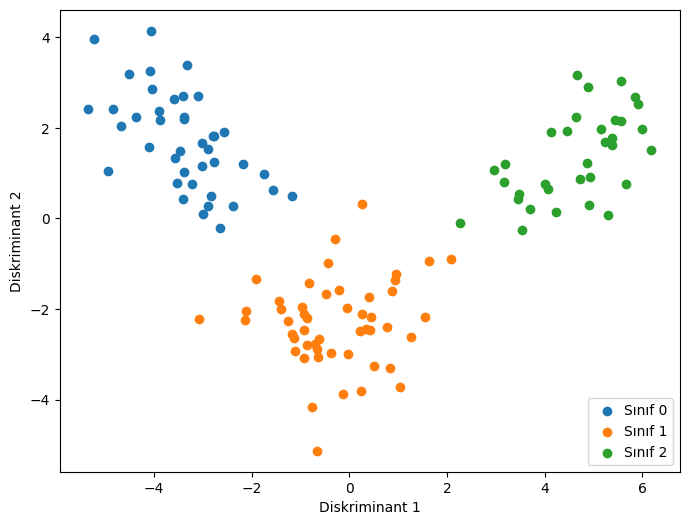

In [66]:
#LDA Uygulama

lda = LDA(n_components=2) #3 almak matematiksel olarak mümkün değil

X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)
X_test_lda = lda.transform(X_test)

#LDA 2D scatter plot
plt.figure(figsize=(8,6))
for label in [0, 1, 2]:
    mask = (y_train == label) 
    plt.scatter(X_train_lda[mask, 0], X_train_lda[mask, 1], label=f'Sınıf {label}')

plt.xlabel('Diskriminant 1')
plt.ylabel('Diskriminant 2')
plt.tight_layout
plt.legend(handletextpad=0.2, loc='lower right')
plt.show()

Makine Öğrenmesi Modelleriının Kurulması

In [67]:
#Modellerin Kurulması

#Logistic Regression
#Ham veri
lr_raw = LogisticRegression(random_state=42)
lr_raw.fit(X_train, y_train);
#PCA verisi
lr_pca = LogisticRegression(random_state=42)
lr_pca.fit(X_train_pca, y_train);
#LDA verisi
lr_lda = LogisticRegression(random_state=42)
lr_lda.fit(X_train_lda, y_train);

#Decision Tree Clasifier
#Ham veri
dt_raw = DecisionTreeClassifier(random_state=42)
dt_raw.fit(X_train, y_train);
#PCA verisi
dt_pca = DecisionTreeClassifier(random_state=42)
dt_pca.fit(X_train_pca, y_train);
#LDA verisi
dt_lda = DecisionTreeClassifier(random_state=42)
dt_lda.fit(X_train_lda, y_train);

#Random Forest Classifier
#Ham veri
rf_raw = RandomForestClassifier(random_state=42)
rf_raw.fit(X_train, y_train);
#PCA verisi
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train);
#LDA verisi
rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train);

#XGBoost Classifier
#Ham veri
xgb_raw = XGBClassifier(random_state=42)
xgb_raw.fit(X_train, y_train);
#PCA verisi
xgb_pca = XGBClassifier(random_state=42)
xgb_pca.fit(X_train_pca, y_train);
#LDA verisi
xgb_lda = XGBClassifier(random_state=42)
xgb_lda.fit(X_train_lda, y_train);

#Naive Bayes (GaussianNB)
#Ham veri
nb_raw = GaussianNB()
nb_raw.fit(X_train, y_train);
#PCA verisi
nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train);
#LDA verisi
nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train);

Model Validation Performanslarının Ölçülmesi

In [68]:
#Validation Performanslarının Ölçülmesi

#Modeller
models = {
    'LR_Raw': (lr_raw, X_val),
    'LR_PCA': (lr_pca, X_val_pca),
    'LR_LDA': (lr_lda, X_val_lda),

    'DT_Raw': (dt_raw, X_val),
    'DT_PCA': (dt_pca, X_val_pca),
    'DT_LDA': (dt_lda, X_val_lda),

    'RF_Raw': (rf_raw, X_val),
    'RF_PCA': (rf_pca, X_val_pca),
    'RF_LDA': (rf_lda, X_val_lda),

    'XGB_Raw': (xgb_raw, X_val),
    'XGB_PCA': (xgb_pca, X_val_pca),
    'XGB_LDA': (xgb_lda, X_val_lda),

    'NB_Raw': (nb_raw, X_val),
    'NB_PCA': (nb_pca, X_val_pca),
    'NB_LDA': (nb_lda, X_val_lda)
}

results = []
for name, (model, X_data) in models.items():
    y_pred = model.predict(X_data)
    y_prob = model.predict_proba(X_data)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred, average='weighted'),
        'Recall': recall_score(y_val, y_pred, average='weighted'),
        'F1-Score': f1_score(y_val, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_val, y_prob, multi_class='ovr') #one versus rest, 0 vs 1,2 mesela
    })

#Tablo
results_df = pd.DataFrame(results)
print(results_df)

      Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0    LR_Raw  1.000000   1.000000  1.000000  1.000000  1.000000
1    LR_PCA  0.944444   0.955556  0.944444  0.945394  1.000000
2    LR_LDA  1.000000   1.000000  1.000000  1.000000  1.000000
3    DT_Raw  0.888889   0.906944  0.888889  0.884568  0.925325
4    DT_PCA  0.944444   0.951389  0.944444  0.944160  0.961039
5    DT_LDA  1.000000   1.000000  1.000000  1.000000  1.000000
6    RF_Raw  0.888889   0.906944  0.888889  0.884568  1.000000
7    RF_PCA  0.944444   0.955556  0.944444  0.945394  1.000000
8    RF_LDA  1.000000   1.000000  1.000000  1.000000  1.000000
9   XGB_Raw  0.888889   0.906944  0.888889  0.884568  1.000000
10  XGB_PCA  1.000000   1.000000  1.000000  1.000000  1.000000
11  XGB_LDA  0.888889   0.913580  0.888889  0.886574  0.991342
12   NB_Raw  0.944444   0.951389  0.944444  0.944160  1.000000
13   NB_PCA  0.944444   0.955556  0.944444  0.945394  1.000000
14   NB_LDA  1.000000   1.000000  1.000000  1.000000  1

En iyi modelin test üzerinde değerlendirilmesi

In [69]:
#Birden fazla mükemmel sonuç alan olduğu için birisi seçilmiştir.

#RF_RAW alınmıştır "en iyi" için.
best_model = lr_raw
X_train_best = X_train
X_test_best = X_test

#En iyi model test üzerinde çalıştırılıyor
y_pred = best_model.predict(X_test_best)
y_prob = best_model.predict_proba(X_test_best)

#Test seti için sonuçlar
print("Test Seti performans metrikleri:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_prob, multi_class='ovr'):.4f}")

Test Seti performans metrikleri:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000


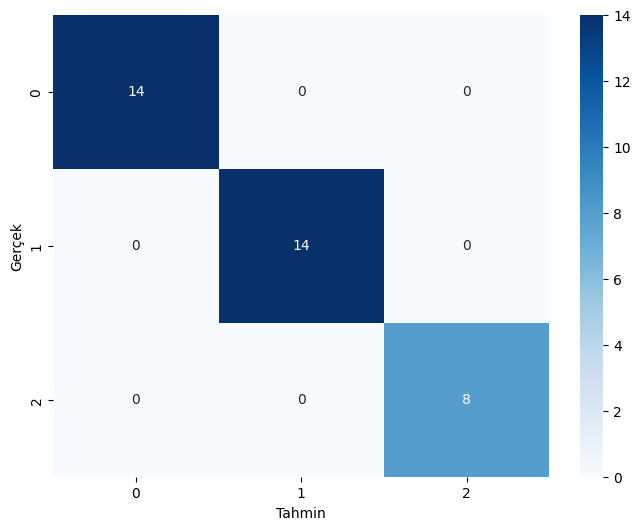

In [70]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()


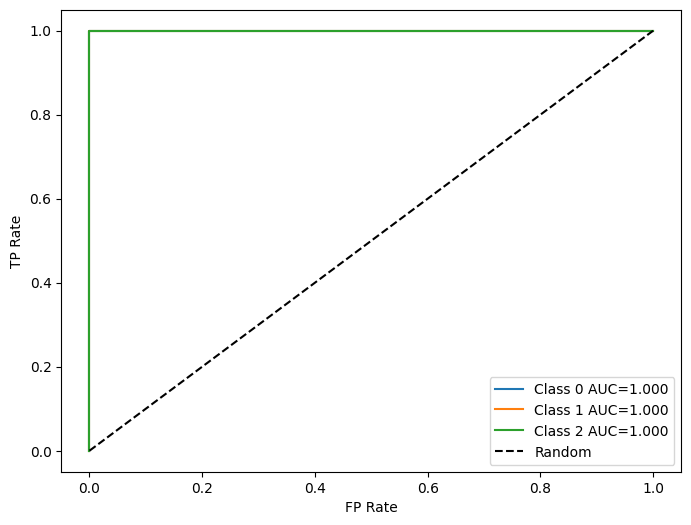

In [71]:
#ROC Eğrisi
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure(figsize=(8,6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} AUC={auc:.3f}')

plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.legend()
plt.show()

SHAP Açıklanabilirlik Analizi

In [72]:
#SHAP Analizi (En iyi model olarak LR-RAW aldık)

#Explainer kurumu
explainer = shap.LinearExplainer(best_model, X_train_best)

#SHAP değerleri hesaplama
shap_values = explainer.shap_values(X_test_best)

#Sanity check
print(f"shap_values type: {type(shap_values)}")
print(f"shap_values shape: {np.array(shap_values).shape}")

shap_values type: <class 'numpy.ndarray'>
shap_values shape: (36, 13, 3)


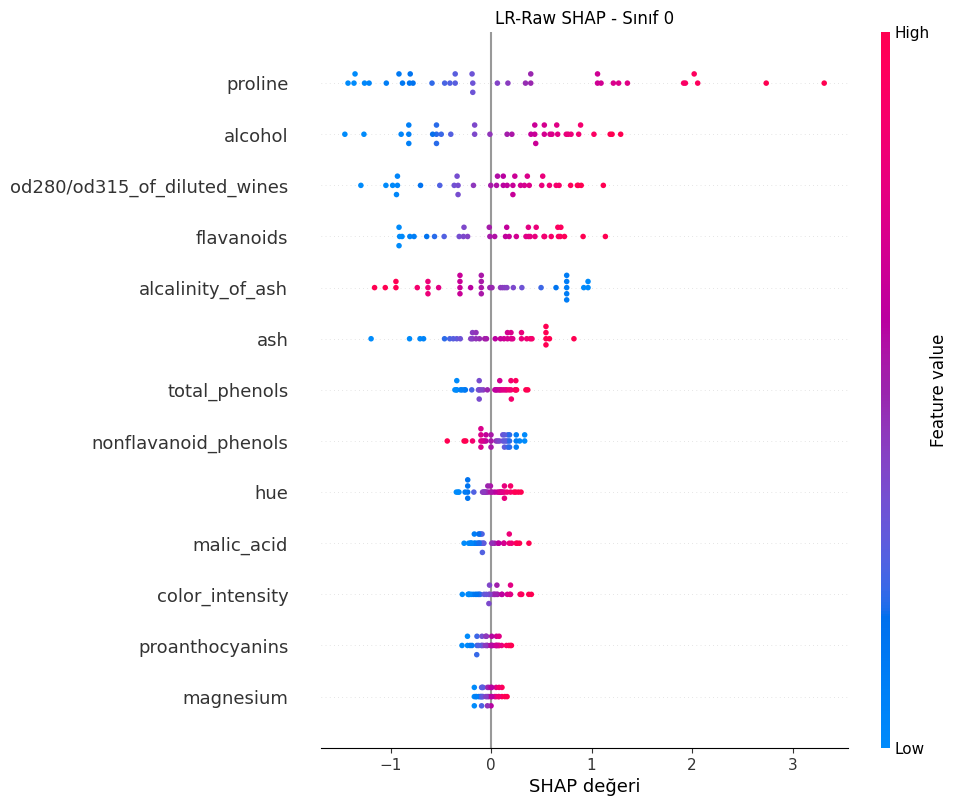

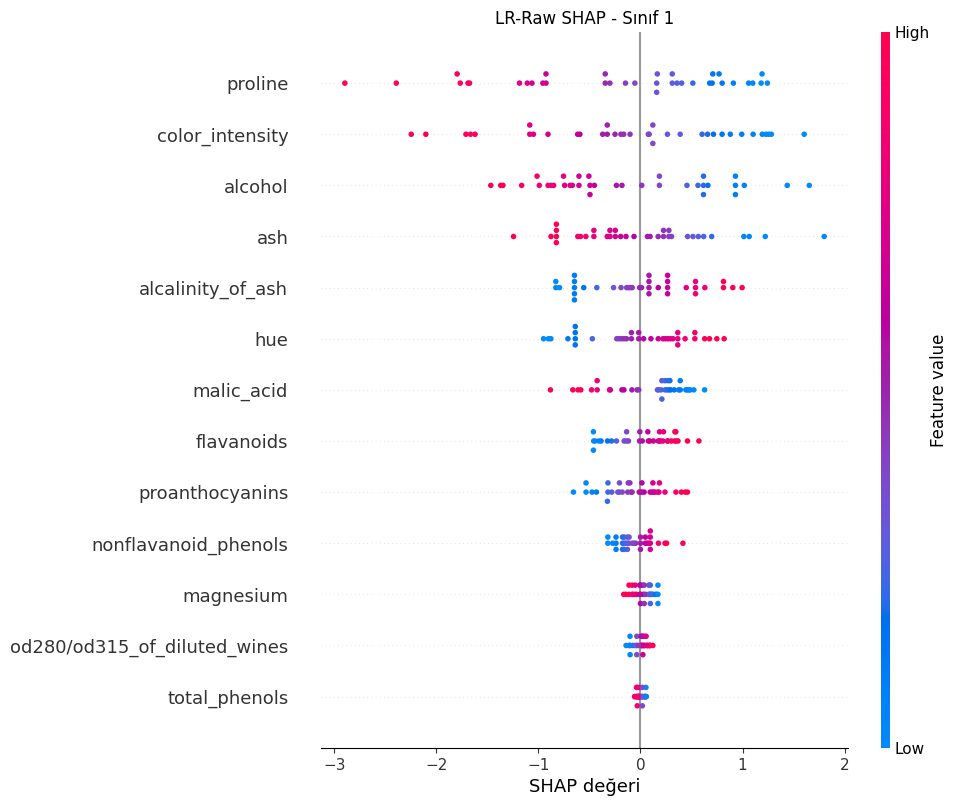

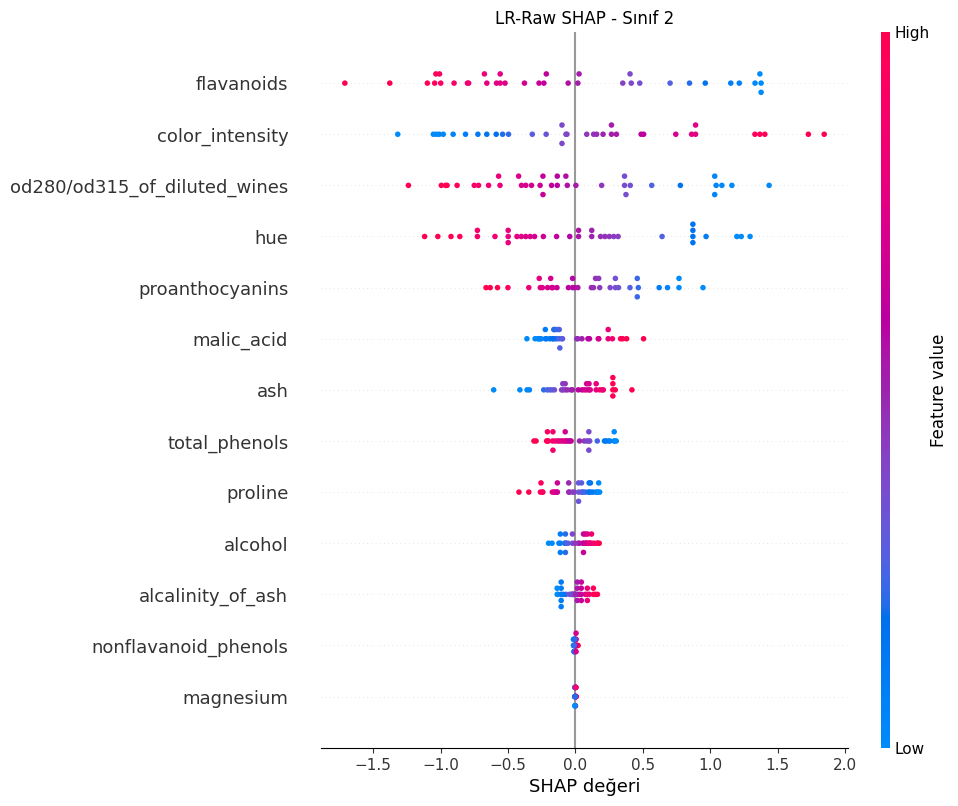

In [73]:
#SHAP Plotları
feature_names = X_df.columns.tolist()
class_names = ["Sınıf 0", "Sınıf 1", "Sınıf 2"]

for i, class_name in enumerate(class_names):
    shap.summary_plot(shap_values[:,:,i], X_test_best,
                      feature_names=feature_names,
                      plot_size=(10, 8), 
                      show=False)
    plt.xlabel("SHAP değeri")
    plt.title(f"LR-Raw SHAP - {class_name}")
    plt.show()

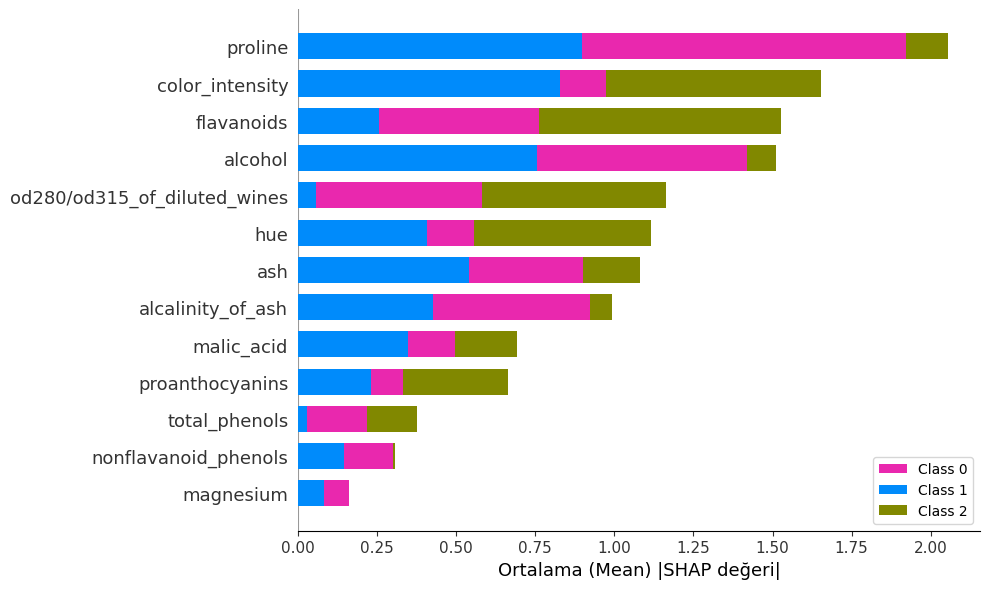

In [74]:
#Bar plot
shap.summary_plot(shap_values, X_test_best,
                  feature_names=feature_names,
                  plot_type="bar",
                  plot_size=(10, 6),
                  show=False)
plt.tight_layout()

order = [1, 0, 2]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in order], [labels[i] for i in order],
           loc='lower right')

plt.xlabel("Ortalama (Mean) |SHAP değeri|")
plt.show()

In [75]:
#Önemli özellikler
mean_shap = np.mean(np.abs(shap_values), axis = (0,2))

importance_df = pd.DataFrame({
    'Özellik': feature_names,
    'Ortalama |SHAP|': mean_shap
}).sort_values('Ortalama |SHAP|', ascending=False)

print(importance_df.to_string(index=False))

                     Özellik  Ortalama |SHAP|
                     proline         0.684415
             color_intensity         0.551306
                  flavanoids         0.508983
                     alcohol         0.503861
od280/od315_of_diluted_wines         0.387789
                         hue         0.371911
                         ash         0.360835
           alcalinity_of_ash         0.331131
                  malic_acid         0.231242
             proanthocyanins         0.221742
               total_phenols         0.125766
        nonflavanoid_phenols         0.102562
                   magnesium         0.054223


In [76]:
#Sınıf bazında önem
mean_shap_per_class = np.mean(np.abs(shap_values), axis=0)  # (13, 3)

print("\nSınıf Bazında Özellik Önemi:")
print(f"{'Özellik':<30} {'Sınıf 0':<12} {'Sınıf 1':<12} {'Sınıf 2':<12}")
print("-" * 65)
for i, name in enumerate(feature_names):
    print(f"{name:<30} {mean_shap_per_class[i,0]:<12.4f} {mean_shap_per_class[i,1]:<12.4f} {mean_shap_per_class[i,2]:<12.4f}")


Sınıf Bazında Özellik Önemi:
Özellik                        Sınıf 0      Sınıf 1      Sınıf 2     
-----------------------------------------------------------------
alcohol                        0.6647       0.7558       0.0910      
malic_acid                     0.1482       0.3469       0.1987      
ash                            0.3589       0.5413       0.1823      
alcalinity_of_ash              0.4967       0.4269       0.0698      
magnesium                      0.0790       0.0813       0.0023      
total_phenols                  0.1886       0.0297       0.1589      
flavanoids                     0.5078       0.2557       0.7635      
nonflavanoid_phenols           0.1538       0.1469       0.0070      
proanthocyanins                0.1017       0.2309       0.3326      
color_intensity                0.1476       0.8270       0.6794      
hue                            0.1489       0.4090       0.5579      
od280/od315_of_diluted_wines   0.5247       0.0570       0.5817 

PCA ve LDA ile indirgenmiş veride SHAP analizi

PCA bileşen sayısı: 4
SHAP shape: (36, 4, 3)


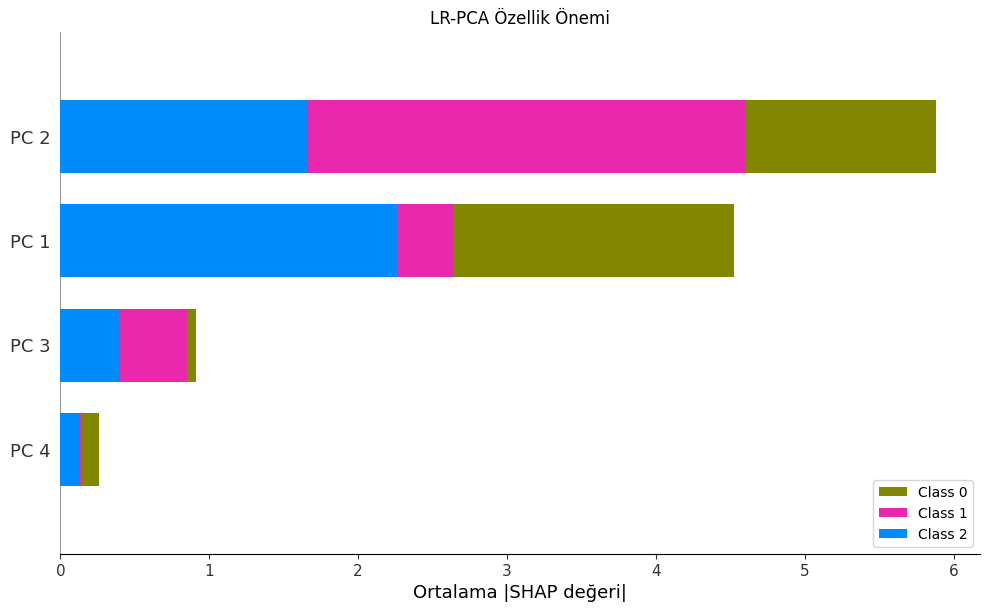

In [77]:
#PCA ve LDA karşılaştırması
#LR-PCA ve LR-LDA kullanılmıştır

#LR-PCA SHAP Analizi
explainer_pca = shap.LinearExplainer(lr_pca, X_train_pca)
shap_values_pca = explainer_pca.shap_values(X_test_PCA)

n_pca = X_train_pca.shape[1]
feature_names_pca = [f"PC {i+1}" for i in range(n_pca)]

print(f"PCA bileşen sayısı: {n_pca}")
print(f"SHAP shape: {shap_values_pca.shape}")

shap.summary_plot(shap_values_pca, X_test_PCA,
                  feature_names=feature_names_pca,
                  plot_type="bar",
                  plot_size=(10, 6),
                  show=False)

order = [2, 1, 0]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in order], [labels[i] for i in order],
           loc='lower right')

plt.xlabel("Ortalama |SHAP değeri|")
plt.title("LR-PCA Özellik Önemi")
plt.show()

LDA bileşen sayısı: 2
SHAP shape: (36, 2, 3)


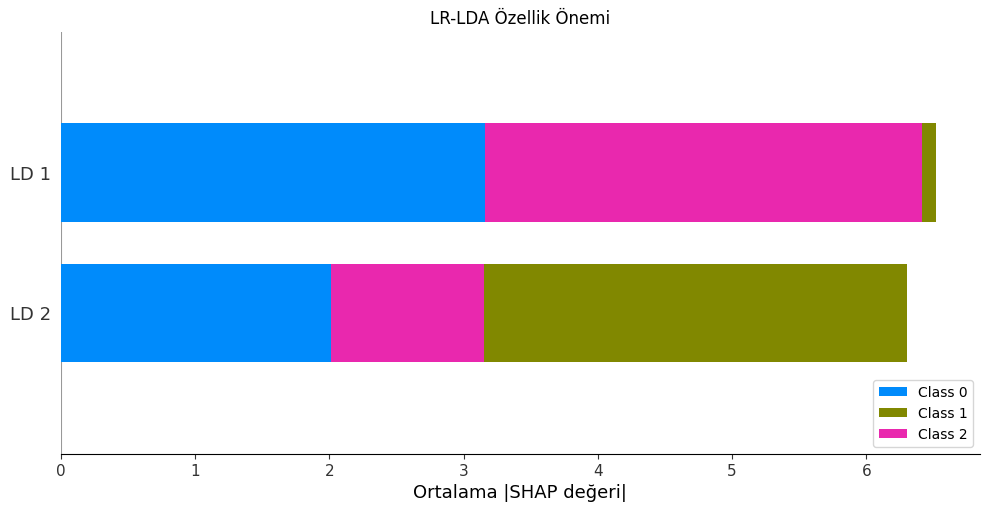

In [78]:
#LR-LDA SHAP analizi

explainer_lda = shap.LinearExplainer(lr_lda, X_train_lda)
shap_values_lda = explainer_lda.shap_values(X_test_lda)

feature_names_lda = ['LD 1', 'LD 2']

print(f"LDA bileşen sayısı: 2")
print(f"SHAP shape: {shap_values_lda.shape}")

shap.summary_plot(shap_values_lda, X_test_lda,
                  feature_names=feature_names_lda,
                  plot_type="bar",
                  plot_size=(10, 5),
                  show=False)

order = [0, 2, 1]
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[i] for i in order], [labels[i] for i in order],
           loc='lower right')
plt.xlabel("Ortalama |SHAP değeri|")
plt.title("LR-LDA Özellik Önemi")
plt.show()